In [3]:
import sys
sys.path.append('..')

import os
import json
from typing import List

import torch
import torch.distributed as dist
from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms.functional import to_pil_image
import transformers
from transformers import AutoTokenizer
from diffusers.models import AutoencoderKL

from config import read_config_from_file
from constants import DEFAULT_IMAGE_START_TOKEN, DEFAULT_IMAGE_END_TOKEN, DEFAULT_PAD_TOKEN, DEFAULT_IMAGE_TOKEN
from diffusion import create_diffusion
from models import MonoFormerForCausalLM

from matplotlib import pyplot as plt

/root/anaconda3/envs/llmdit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def preprocess_single_inputs(tokenizer: transformers.PreTrainedTokenizer, inputs: List[str], max_length=512, device='cuda'):
    """
    Steps to preprocess inputs:
    1. add special geenration tokens after inputs: <|im_start|><image><|im_end|>
    2. add bos token before inputs
    3. tokenize inputs
    4. replace tokens after bos and before <|im_start|> with padding tokens to form unconditional inputs
    5. concatenate conditional inputs and unconditional inputs along batch dimension
    6. create attention masks by masking padding tokens
    7. create noise image indices
    """
    input_ids = tokenizer(
        inputs,
        max_length=max_length,
        truncation=True,
        add_special_tokens=False,
        # return_tensors="pt",
    )['input_ids']
    
    input_ids = [torch.tensor(i) for i in input_ids]
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)

    # FIXME: replace pad token after <|im_start|> with <image>, this is due to tokenizer cannot correctly tokenize <image> after <|im_start|>
    im_start_token_id = tokenizer.convert_tokens_to_ids(DEFAULT_IMAGE_START_TOKEN)
    im_end_token_id = tokenizer.convert_tokens_to_ids(DEFAULT_IMAGE_END_TOKEN)
    image_token_id = tokenizer.convert_tokens_to_ids(DEFAULT_IMAGE_TOKEN)
    for cur_input_ids in input_ids:
        for idx in torch.where(cur_input_ids == im_start_token_id):
            if cur_input_ids[idx + 1] == tokenizer.pad_token_id:
                cur_input_ids[idx + 1] = image_token_id

    attention_mask = input_ids.ne(tokenizer.pad_token_id)

    noise_image_indices = [[0] for _ in range(len(input_ids))]
 
    return {
        'input_ids': input_ids.to(device),
        'attention_mask': attention_mask.to(device),
        'noise_image_indices': noise_image_indices,
    }


In [5]:
ckpt = '/root/paddlejob/workspace/monoformer_imagenet_res256_bf16_bs32_lr1e-4/'
use_ema = True
vae_pretrained_path = 'stabilityai/sd-vae-ft-mse'

In [14]:
cfg = read_config_from_file(os.path.join(ckpt, 'cfg.json'))

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(ckpt)

# load model
if use_ema:
    model = MonoFormerForCausalLM.from_pretrained(os.path.join(ckpt, 'ema'))
else:
    model = MonoFormerForCausalLM.from_pretrained(ckpt)
model.eval().cuda()

# load vae
vae = AutoencoderKL.from_pretrained(vae_pretrained_path).cuda()

# create diffusion
num_sampling_steps = 20
w = 256
h = 256
cfg_scale = 4
diffusion = create_diffusion(str(num_sampling_steps))
latent_w, latent_h = w // 8, h // 8
z = torch.randn([1, 4, latent_w, latent_h], device="cuda")
z = z.repeat(2, 1, 1, 1)

use_chat_template = cfg.get('use_chat_template', False)
if use_chat_template:
    DEFAULT_CHAT_TEMPLATE = "{%- for message in messages %}{%- if message['role'] == 'user' %}{{- bos_token + '### Human: ' + message['content'].strip() }}{%- elif message['role'] == 'assistant' %}{{- '### Assistant: ' + message['content'] + eos_token }}{%- endif %}{%- if loop.last and add_generation_prompt %}{{- '### Assistant: '}}{%- endif %}{%- endfor %}"
    tokenizer.chat_template = cfg.get('chat_template', DEFAULT_CHAT_TEMPLATE)


def generate_image(prompt):
    if use_chat_template:
        conversations = [
            [{"role": "user", "content": f"{prompt}"}, {"role": "assistant", "content": f"{DEFAULT_IMAGE_START_TOKEN}{DEFAULT_PAD_TOKEN}{DEFAULT_IMAGE_END_TOKEN}"}],
            [{"role": "user", "content": ""}, {"role": "assistant", "content": f"{DEFAULT_IMAGE_START_TOKEN}{DEFAULT_PAD_TOKEN}{DEFAULT_IMAGE_END_TOKEN}"}],
        ]
        inputs = [
            tokenizer.apply_chat_template(conversations[0], tokenize=False, add_generation_prompt=False),
            tokenizer.apply_chat_template(conversations[1], tokenize=False, add_generation_prompt=False)
        ]
    else:
        inputs = [
            f"{tokenizer.bos_token}{prompt}{DEFAULT_IMAGE_START_TOKEN}{DEFAULT_PAD_TOKEN}{DEFAULT_IMAGE_END_TOKEN}",
            f"{tokenizer.bos_token}{DEFAULT_IMAGE_START_TOKEN}{DEFAULT_PAD_TOKEN}{DEFAULT_IMAGE_END_TOKEN}"
        ]

    inputs_dict = preprocess_single_inputs(tokenizer, inputs)
    inputs_dict['cfg_scale'] = cfg_scale

    samples = diffusion.p_sample_loop(
        model.forward_with_cfg, z.shape, z, clip_denoised=False,
        model_kwargs=inputs_dict, progress=True, device="cuda",
    )

    samples = samples[:1]

    samples = vae.decode(samples.float() / 0.18215).sample
    samples = (samples + 1.) / 2.
    samples.clamp_(0., 1.)
    img = to_pil_image(samples[0])

    img.save(f"output_image.png")

    return img



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Text(0.5, 0.01, 'Please generate an image of junco')

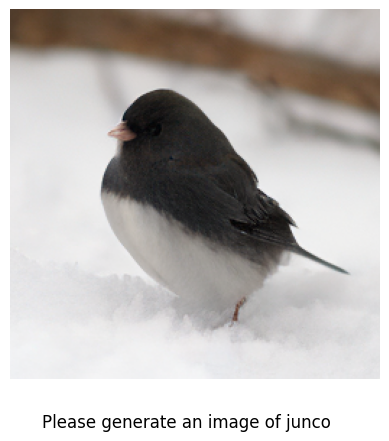

In [15]:
prompt = "Please generate an image of junco"

img = generate_image(prompt)

plt.imshow(img)
plt.axis('off')
plt.figtext(0.5, 0.01, prompt, wrap=True, horizontalalignment='center', fontsize=12)